(page:how-to-stacking)=
# Stacking
A common ApRES data processing step to reduce the level is stacking. This involves averaging returns from multiple chirps in a burst so that the random noise tends to cancel out while the signal (reflections from sub-surface reflectors) remains. 


In [3]:
import sys
sys.path.append("../../../xapres") 
import xapres as xa

Let's start by loading some data collected on Thwaites Glacier, West Antarctica.

In [10]:
data = xa.load.generate_xarray(directory='../data/thwaites/')
data

<xarray.Dataset> Size: 193MB
Dimensions:          (time: 2, chirp_time: 40001, chirp_num: 100,
                      attenuator_setting_pair: 1, profile_range: 39999)
Coordinates:
  * time             (time) datetime64[ns] 16B 2023-02-12T04:37:04 2023-02-13...
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (time) <U40 320B '../data/thwaites/DATA2023-02-12-0437.D...
    burst_number     (time) int64 16B 0 1
    AFGain           (attenuator_setting_pair) int64 8B -4
    attenuator       (attenuator_setting_pair) float64 8B 22.0
    orientation      (time) <U7 56B 'unknown' 'unknown'
  * profile_range    (profile_range) float64 320kB 0.0 0.2103 ... 8.411e+03
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 64MB ...
    latitude         (time) float64 16B 0.0 0.0
    longitude        (time) float64 16B 0.0 0.0
    battery_voltage  (time) float64 16B 12.39 12.39
    temperature_1    (time) float64 16B -18.55 -18.35
    temperature_2    (time) float64 16B -13.66 -13.85
    profile          (time, chirp_num, attenuator_setting_pair, profile_range) complex128 128MB ...
Attributes:
    constants:   {'c': 300000000.0, 'K': 200000000.0, 'f_1': 200000000, 'f_2'...
    processing:  Created on 2025-01-09 11:07:52.916600

## Stacking is `.mean(dim='chirp_num')` in xApRES
In xarray, taking the average on along a specific dimension is east using the `mean` method. Therefore stacking in xApRES is simply

In [11]:
data_stacked = data.mean(dim='chirp_num')

This is the simplest way to stack in xApRES. It averages both the `chirp` and `profile` variables along the dimension `chirp_num`. 

To see the impact of stacking we can plot the power (in decibels) of a single profile and of the stacked profile and compare the two at different depths. 

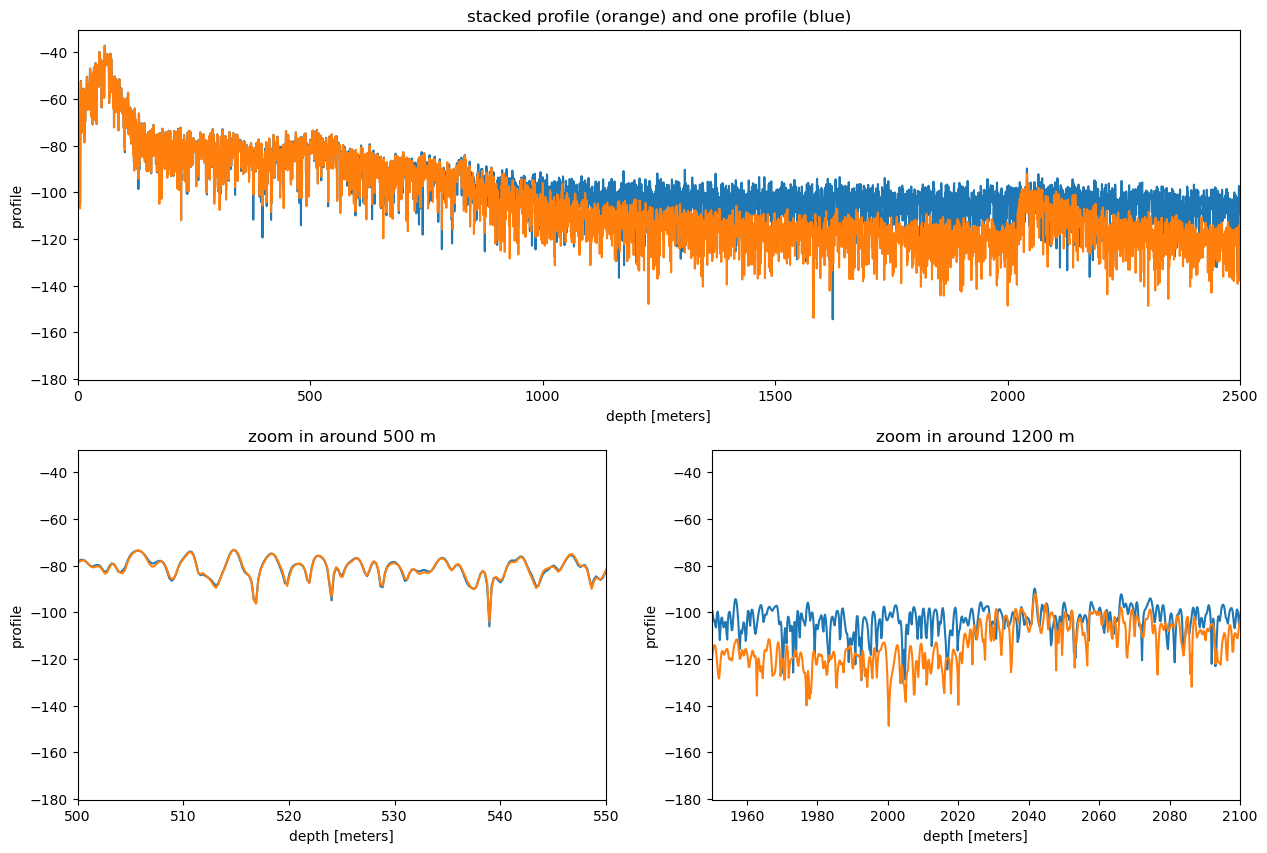

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, :])  # Top subplot spanning both columns
ax2 = fig.add_subplot(gs[1, 0])  # Bottom left subplot
ax3 = fig.add_subplot(gs[1, 1])  # Bottom right subplot

for ax in [ax1, ax2, ax3]:
    data.profile.isel(time=0, chirp_num=0).dB().plot(ax=ax, x='profile_range', xlim=[0, 2500], label='one profile')
    data_stacked.profile.isel(time=0).dB().plot(ax=ax, x='profile_range', xlim=[0, 2500], label = 'all 100 profiles averaged together')

ax1.set_xlim([0, 2500])
ax2.set_xlim([500, 550])
ax3.set_xlim([1950, 2100])

ax1.set_title('stacked profile (orange) and one profile (blue)')
ax2.set_title('zoom in around 500 m')
ax3.set_title('zoom in around the bed');

The bottom left panel above shows that at relatively shallow depths the stacked profile and the single profile are very similar. This is because the signal-to-noise ratio is high at these depths. In the top panel we see that at deeper depths, great than around 900 m, the stacked profile has much lower power than the single profile. This can help to identify details at these depths. In particular, the bed reflector at around 2040 m is more prominent in the stacked profile. 

## Order of operations
Interestingly, you can either average all the chirps and compute the fft of the result, or you can compute the fft of each chirp and average the resulting complex profiles. 

In [38]:
average_chirps_then_fft = data.chirp.mean(dim='chirp_num').computeProfile()
fft_then_average_profiles = data.chirp.computeProfile().mean(dim='chirp_num')

In [47]:
import numpy as np
np.allclose(average_chirps_then_fft, fft_then_average_profiles)

True

## Summary
Stacking is `.mean(dim='chirp_num')` in xApRES.